In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os, re, gc
import h5py
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

batch = 256; n_pols = 9
path_dir = '/mnt/ML-drive/Artem/Carbon_test/'
class_names_ft = [k for k in os.listdir(path_dir) if ('C60' in k or 'C100' in k)]
test_types = ['sig','bckg']
id_header = ['HeaderID','ViewID','GrainID','pol0','pol1','pol2','pol3','pol4','pol5','pol6','pol7','tr_flag','n_pol']
feat_names = ['x','y','z','lx','ly','phi','npx','vol','eps']
test_names = ['Header','View','Grain','Bar_sh','Phy','pred']

mod_thresh = {'c100':1-1e-4,'c60':1-1e-3,'c30':1-1e-4}

In [11]:
res_all = np.ones((0,len(test_names)+3))
for tt in test_types:
    for name in class_names_ft:
        name_ = (name.split('k')[0]).lower()
        tmp_res = pd.read_csv(path_dir+name+'/'+name_+'_'+tt+'_pred_grains.txt', names=test_names)
        tmp_res['inv_pred'] = (1-tmp_res['pred']+1e-10)**-1
        tmp_res['carb'] = name_
        tmp_res['type'] = tt
        if tt=='sig': tmp_res['type'][tmp_res['pred']>mod_thresh[name_]] = 'nn_'+tt
        else: tmp_res['type'][tmp_res['pred']<mod_thresh[name_]] = 'nn_'+tt
        res_all = np.vstack((res_all, tmp_res.values))
        #sns.scatterplot(x='Bar_sh',y='pred',data=res[name_+'-'+tt])
res_all = pd.DataFrame(res_all, columns=test_names+['inv_pred','carb','type'])
res_all.head(5)

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Header,View,Grain,Bar_sh,Phy,pred,inv_pred,carb,type
0,1,0,1,0.0899966,-0.423279,0.999999,1.67744e+06,c100,nn_sig
1,1,0,11,0.0840073,0.382205,0.999997,381286,c100,nn_sig
2,1,0,20,0.0580553,-0.11885,0.999942,17119.6,c100,nn_sig
3,1,0,22,0.0542002,-0.596416,0.999998,645236,c100,nn_sig
4,1,0,23,0.0489081,1.38551,0.999989,89239.7,c100,nn_sig


# Probability scatter plot.
### Higher points mean higher probability of being signal
$InvProb=(1-P)^{-1}$

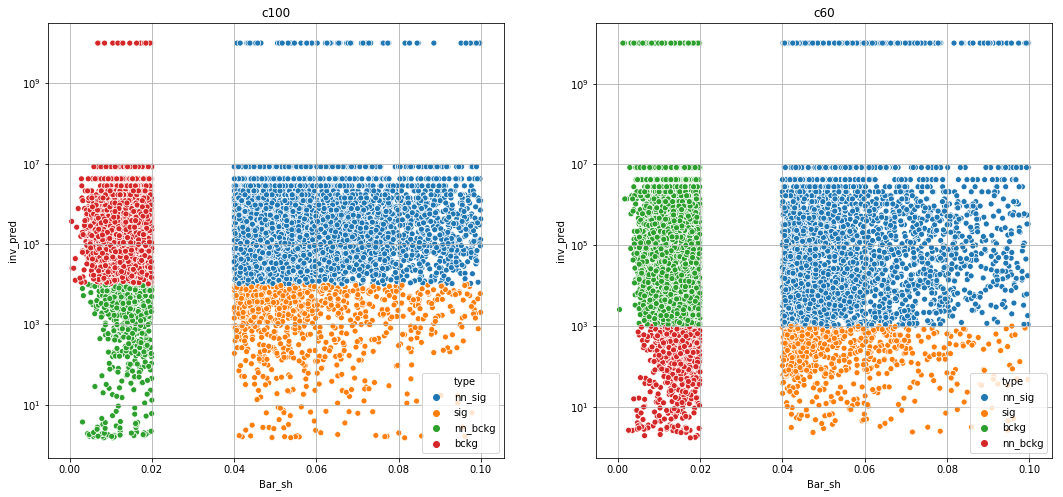

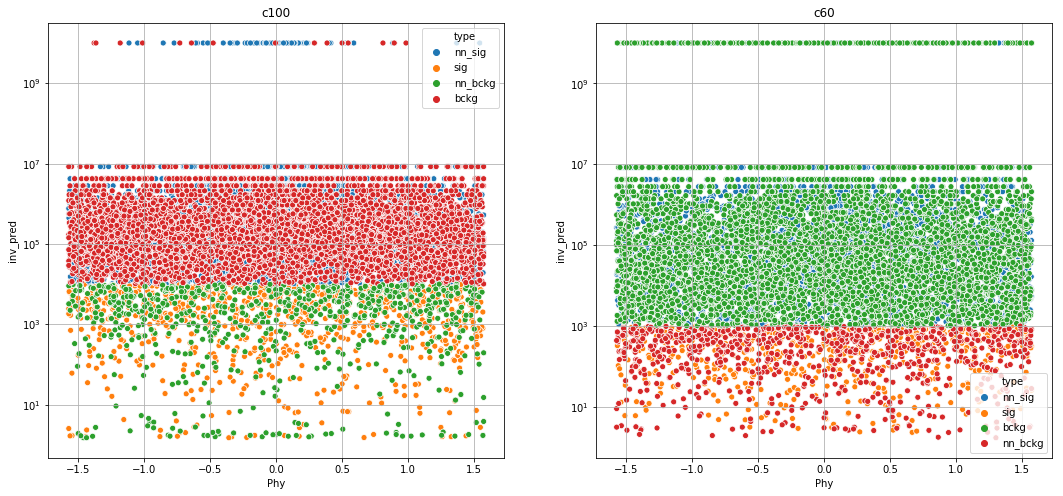

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for i,tt in enumerate(class_names_ft):
    tt = (tt.split('k')[0]).lower()
    axes[i].grid()
    axes[i].set_yscale('log')
    axes[i].set_title(tt)
    sns.scatterplot(x='Bar_sh',y='inv_pred',hue='type',data=res_all[res_all['carb']==tt], ax=axes[i])
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
for i,tt in enumerate(class_names_ft):
    tt = (tt.split('k')[0]).lower()
    axes[i].grid()
    axes[i].set_yscale('log')
    axes[i].set_title(tt)
    sns.scatterplot(x='Phy',y='inv_pred',hue='type',data=res_all[res_all['carb']==tt], ax=axes[i])
plt.show()

## Phi distributions.

* On the left are samples preselected by Valerio as signal. 
* On the right - background
    * nn - means 'neural network selected'

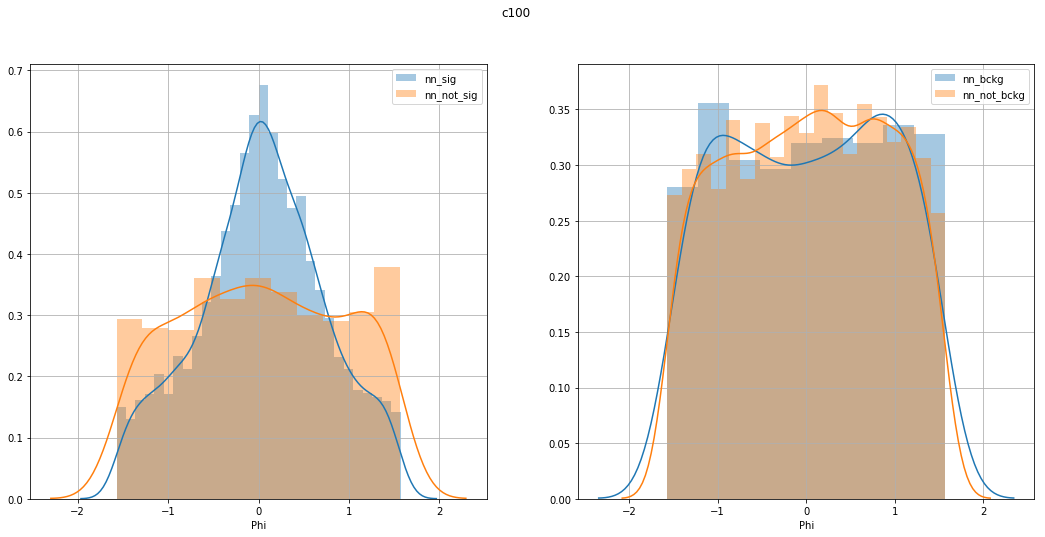

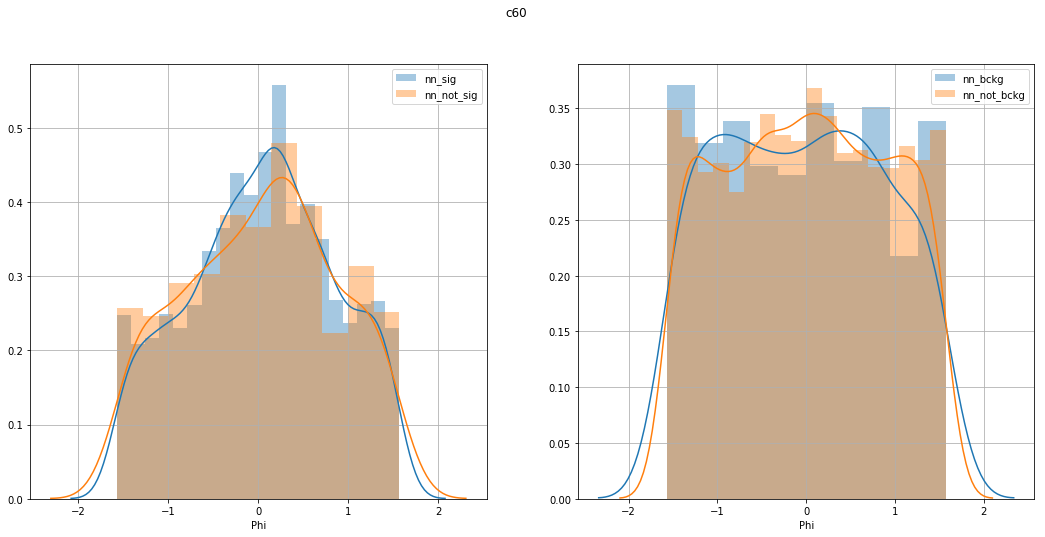

In [25]:
for carb in class_names_ft:
    carb = (carb.split('k')[0]).lower()
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    res_tmp = res_all[res_all['carb']==carb]
    for i,tt in enumerate(test_types):
        sig_tmp = res_tmp[res_tmp['type']=='nn_'+tt]
        sns.distplot(np.array(sig_tmp['Phy'],dtype=float),label='nn_'+tt, ax=axes[i])
        bckg_tmp = res_tmp[res_tmp['type']==tt]
        sns.distplot(np.array(bckg_tmp['Phy'],dtype=float),label='nn_not_'+tt, ax=axes[i])
        axes[i].set_xlabel('Phi')
        axes[i].legend()
        axes[i].grid()
    fig.suptitle(carb)
    plt.show()

## Probability distributions.

* On the left are samples preselected by Valerio as signal. 
* On the right - background
    * nn - means 'neural network selected'

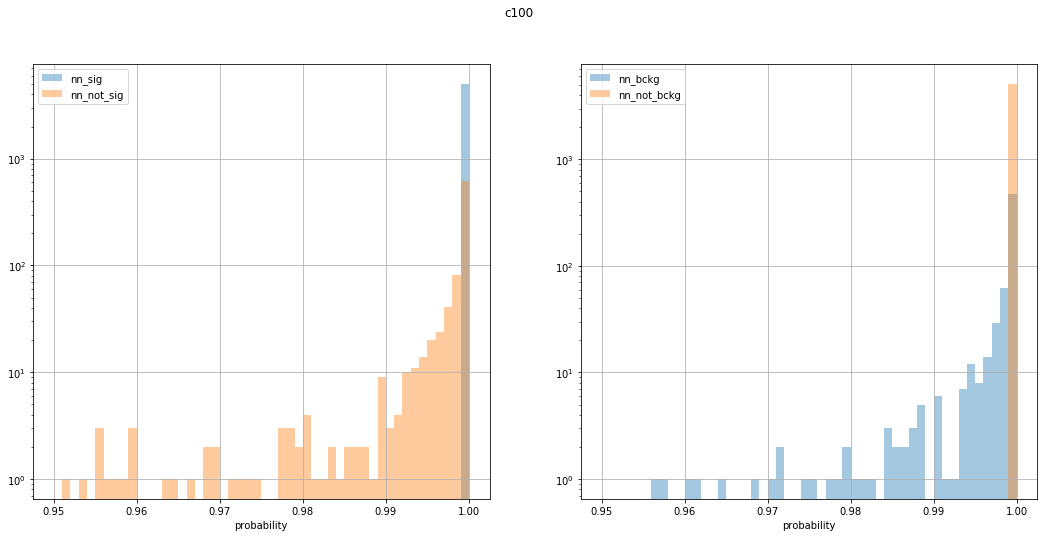

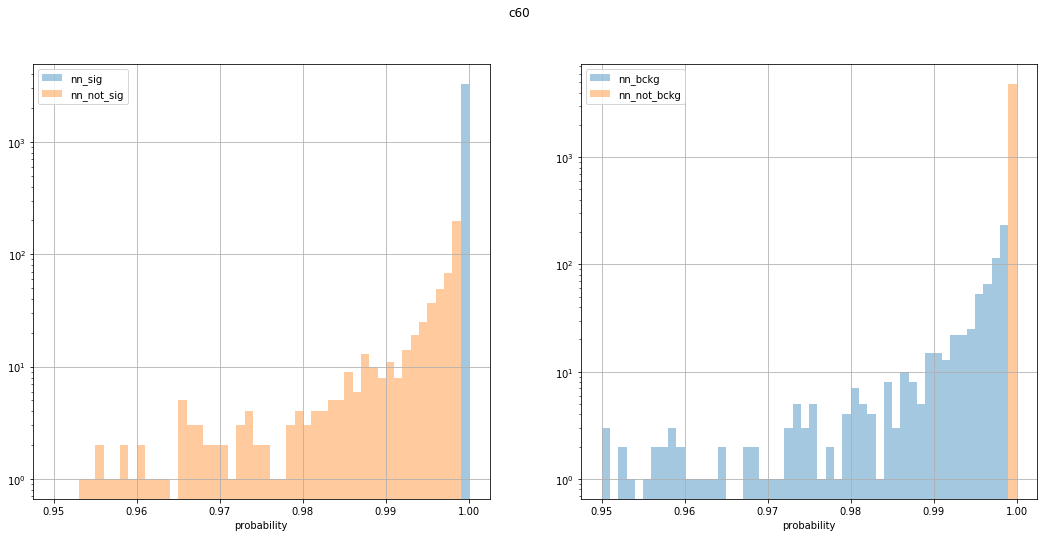

In [30]:
for carb in class_names_ft:
    carb = (carb.split('k')[0]).lower()
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    res_tmp = res_all[res_all['carb']==carb]
    for i,tt in enumerate(test_types):
        sig_tmp = res_tmp[res_tmp['type']=='nn_'+tt]
        sns.distplot(np.array(sig_tmp['pred'],dtype=float),label='nn_'+tt, ax=axes[i], kde=False, hist_kws={'range':(0.95,1)})
        bckg_tmp = res_tmp[res_tmp['type']==tt]
        sns.distplot(np.array(bckg_tmp['pred'],dtype=float),label='nn_not_'+tt, ax=axes[i], kde=False, hist_kws={'range':(0.95,1)})
        axes[i].set_xlabel('probability')
        axes[i].set_yscale('log')
        axes[i].legend()
        axes[i].grid()
    fig.suptitle(carb)
    plt.show()

## Barycenter shift distributions.

* On the left are samples preselected by Valerio as signal. 
* On the right - background
    * nn - means 'neural network selected'

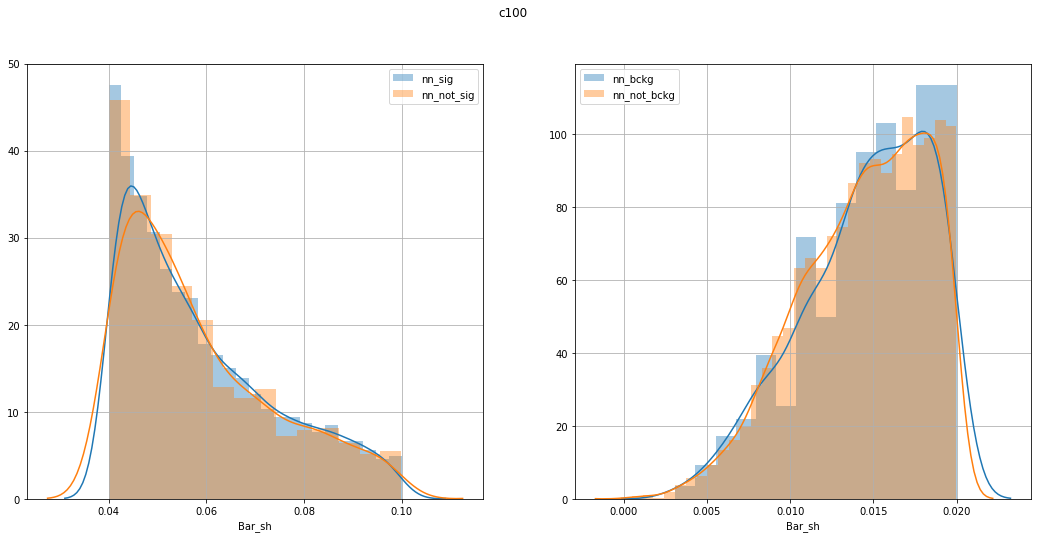

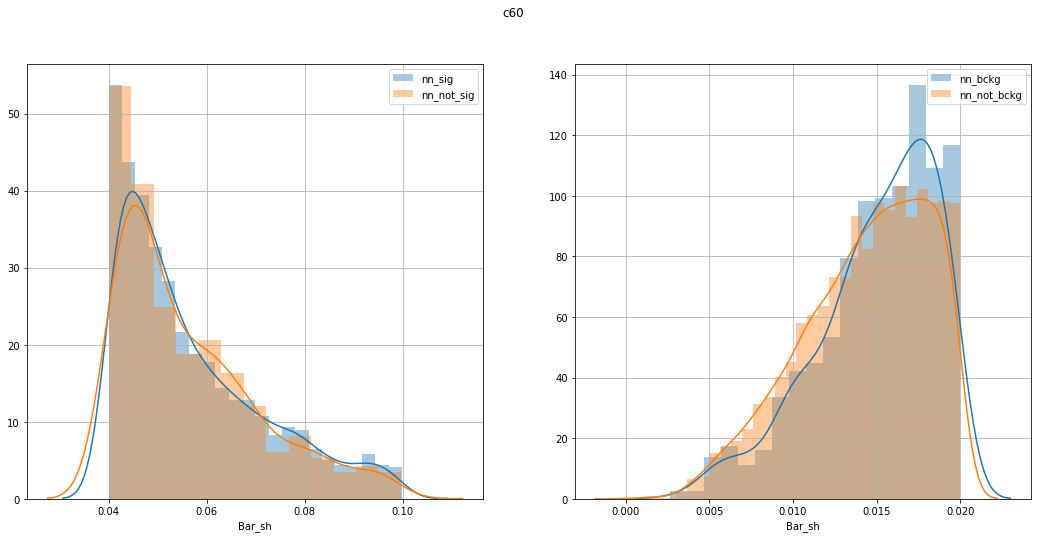

In [34]:
for carb in class_names_ft:
    carb = (carb.split('k')[0]).lower()
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    res_tmp = res_all[res_all['carb']==carb]
    for i,tt in enumerate(test_types):
        sig_tmp = res_tmp[res_tmp['type']=='nn_'+tt]
        sns.distplot(np.array(sig_tmp['Bar_sh'],dtype=float),label='nn_'+tt, ax=axes[i])
        bckg_tmp = res_tmp[res_tmp['type']==tt]
        sns.distplot(np.array(bckg_tmp['Bar_sh'],dtype=float),label='nn_not_'+tt, ax=axes[i])
        axes[i].set_xlabel('Bar_sh')
        axes[i].legend()
        axes[i].grid()
    fig.suptitle(carb)
    plt.show()

## Overall distributions.
### Classes are only related to NN output (not Valerio's preselection)

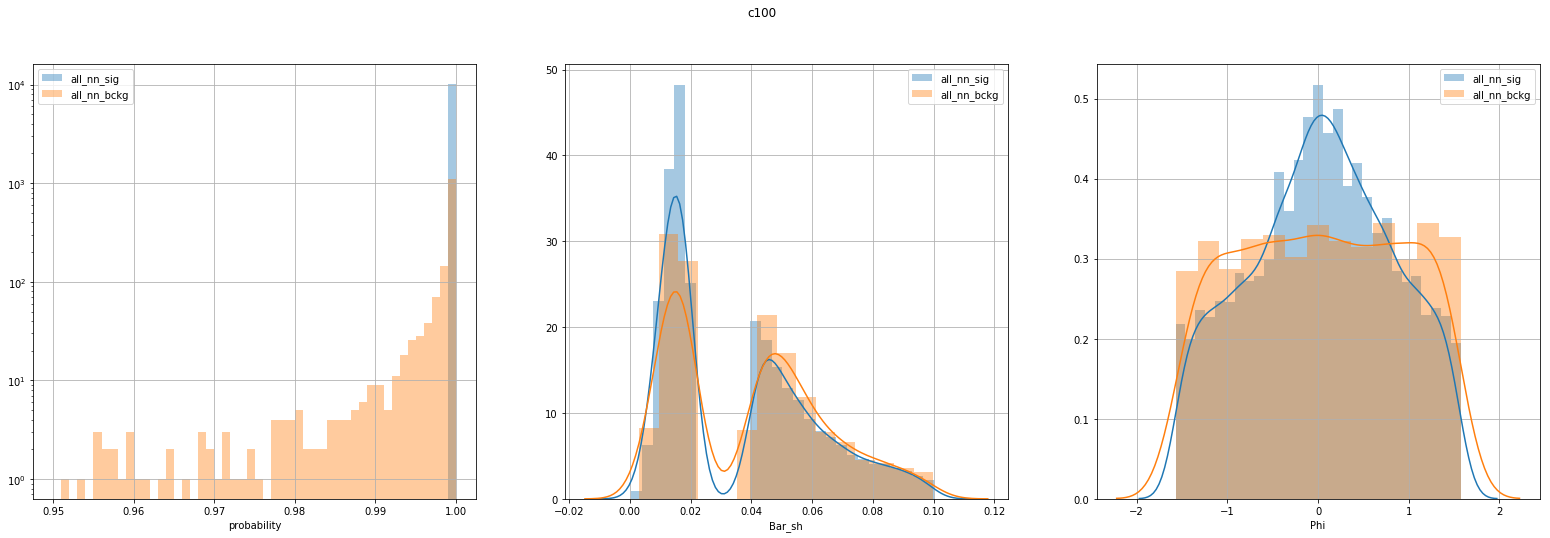

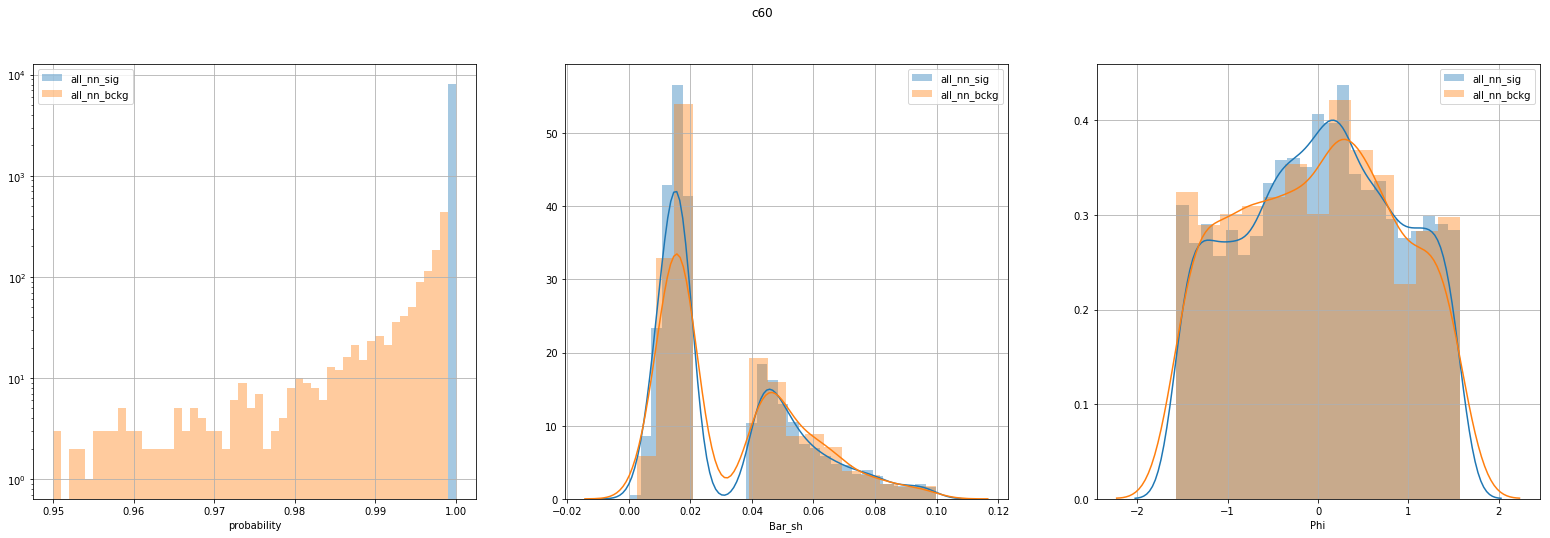

In [63]:
for carb in class_names_ft:
    carb = (carb.split('k')[0]).lower()
    fig, axes = plt.subplots(1, 3, figsize=(27, 8))
    res_tmp = res_all[res_all['carb']==carb]
    mask_tmp = np.zeros(res_all.shape[0], dtype=bool); mask_tmp[list(res_tmp.index)] = True
    
    sig_ind = set(res_tmp[res_tmp['type']=='nn_sig'].index) | set(res_tmp[res_tmp['type']=='bckg'].index)
    mask = np.zeros(res_all.shape[0], dtype=bool); mask[list(sig_ind)] = True; mask = mask[mask_tmp]
    sig_tmp = res_tmp[mask]
    bckg_ind = set(res_tmp[res_tmp['type']=='nn_bckg'].index) | set(res_tmp[res_tmp['type']=='sig'].index)
    mask = np.zeros(res_all.shape[0], dtype=bool); mask[list(bckg_ind)] = True; mask = mask[mask_tmp]
    bckg_tmp = res_tmp[mask]
    
    sns.distplot(np.array(sig_tmp['pred'],dtype=float),label='all_nn_sig', ax=axes[0], kde=False, hist_kws={'range':(0.95,1)})
    sns.distplot(np.array(bckg_tmp['pred'],dtype=float),label='all_nn_bckg', ax=axes[0], kde=False, hist_kws={'range':(0.95,1)})
    axes[0].set_xlabel('probability')
    axes[0].set_yscale('log')
    sns.distplot(np.array(sig_tmp['Bar_sh'],dtype=float),label='all_nn_sig', ax=axes[1])
    sns.distplot(np.array(bckg_tmp['Bar_sh'],dtype=float),label='all_nn_bckg', ax=axes[1])
    axes[1].set_xlabel('Bar_sh')
    sns.distplot(np.array(sig_tmp['Phy'],dtype=float),label='all_nn_sig', ax=axes[2])
    sns.distplot(np.array(bckg_tmp['Phy'],dtype=float),label='all_nn_bckg', ax=axes[2])
    axes[2].set_xlabel('Phi')
    
    for i in range(3):
        axes[i].legend()
        axes[i].grid()
    fig.suptitle(carb)
    plt.show()